In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import pandas as pd
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

In [126]:
!scp pi@192.168.1.189:hydrofarm/data/sensor_data.csv ../data/

sensor_data.csv                               100%   13KB   6.3KB/s   00:02    


In [107]:
sensor = pd.read_csv('../data/sensor_data.csv', names=['ts', 'temperature', 'light', 'moisture'])
sensor['ts'] = pd.to_datetime(sensor.ts)
sensor.set_index('ts', inplace=True)
sensor.tail()

,temperature,light,moisture
ts,,,
2018-12-04 13:55:01,24.823596,52,43
2018-12-04 14:00:01,25.176613,49,43
2018-12-04 14:05:01,24.823596,50,43
2018-12-04 14:10:02,24.823596,49,43
2018-12-04 14:15:01,24.823596,43,42


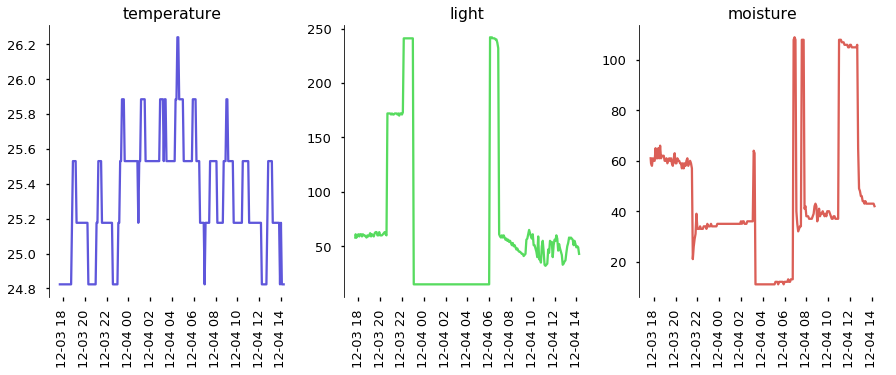

In [70]:
# finest granularity
cp = sns.color_palette('hls', 3)
plt.figure(figsize=(15,5))
for m,measure in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,m+1)
    plt.plot(sensor[measure], '-', color=cp.pop())
    plt.title(measure)
    plt.xticks(rotation=90)
sns.despine(bottom=True)

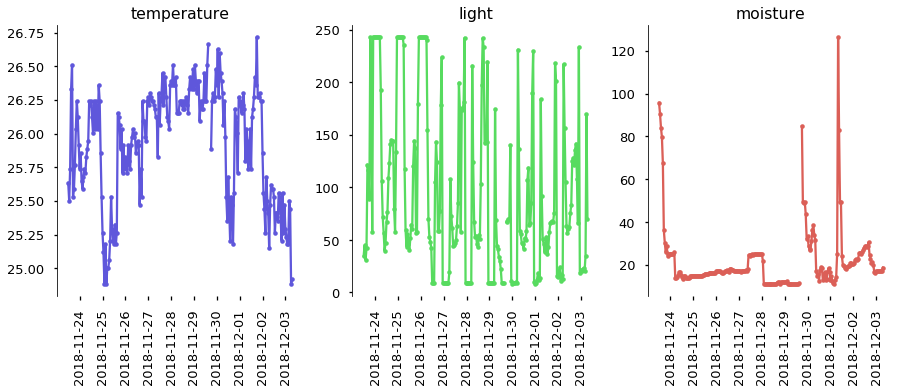

In [64]:
# agg to an hour
cp = sns.color_palette('hls', 3)
plt.figure(figsize=(15,5))
for m,measure in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,m+1)
    plt.plot(sensor[measure].resample('H').mean(), '.-', color=cp.pop())
    plt.title(measure)
    plt.xticks(rotation=90)
#plt.ylim(0,50)
sns.despine(bottom=True)

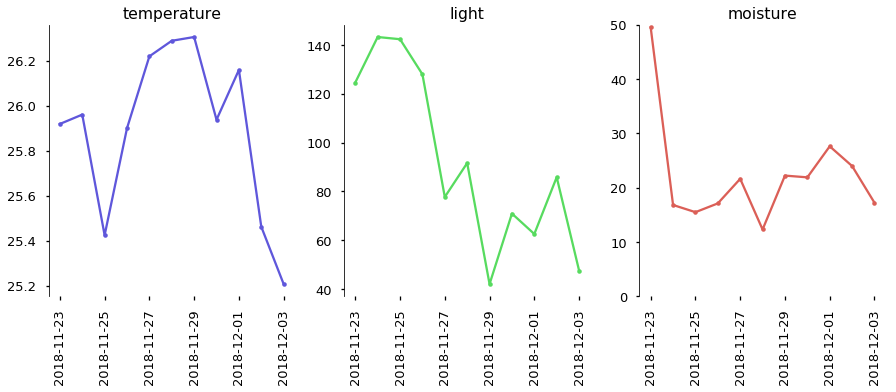

In [61]:
# agg to a day
cp = sns.color_palette('hls', 3)
plt.figure(figsize=(15,5))
for m,measure in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,m+1)
    plt.plot(sensor[measure].resample('D').mean(), '.-', color=cp.pop())
    plt.title(measure)
    plt.xticks(rotation=90)
plt.ylim(0,50)
sns.despine(bottom=True)

Conclusions: the ambient temperature is pretty stable, varying only within a few degrees. It seems higher than it should be though....

The light follows a predictable pattern: the reading is high at night time (high valued reading) and gradually lowers during the day. It begins to darken again as the sun sets by we'll often turn a light on in the room briefly for dinner. Note that I changed the lighting schedule such that lights turn on from midnight to 6am on 11/26 (when the sprouts started). 

Moisture, after being initially very high (dry), has settled around 15. This seems to imply that after a couple waterings the vermiculite has been saturated. 

# what are the daily patterns?

In [124]:
sensor = pd.read_csv('../archive/sensor_data_2018_12_03.csv', names=['ts', 'temperature', 'light', 'moisture'])
sensor['ts'] = pd.to_datetime(sensor.ts)
sensor.tail()

,ts,temperature,light,moisture
2796,2018-12-03 07:33:00,24.823596,69,19
2797,2018-12-03 07:38:00,24.823596,67,19
2798,2018-12-03 07:43:00,24.823596,68,19
2799,2018-12-03 07:48:00,25.176613,71,19
2800,2018-12-03 07:53:00,25.530488,69,19


In [125]:
sensor.to_csv('sensor_backup.csv', index=False)

/Users/stolentino/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


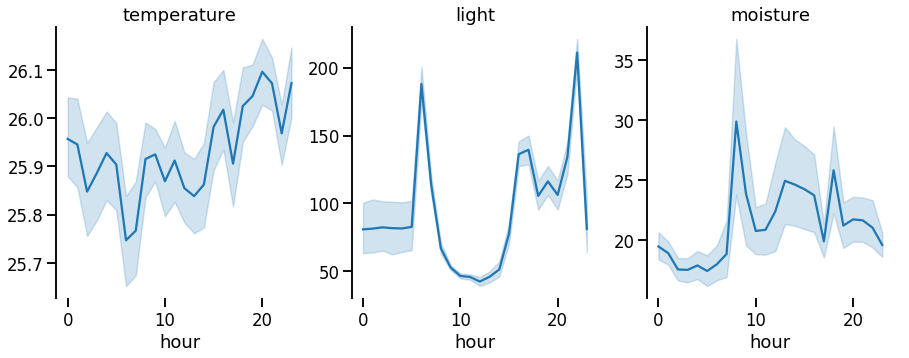

In [28]:
# time series distribution
plt.figure(figsize=(15,5))
for s,sense in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,s+1)
    sns.lineplot(x='hour', y=sense, data=sensor)
    plt.title(sense)
    sns.despine(bottom=True)
    plt.ylabel('')

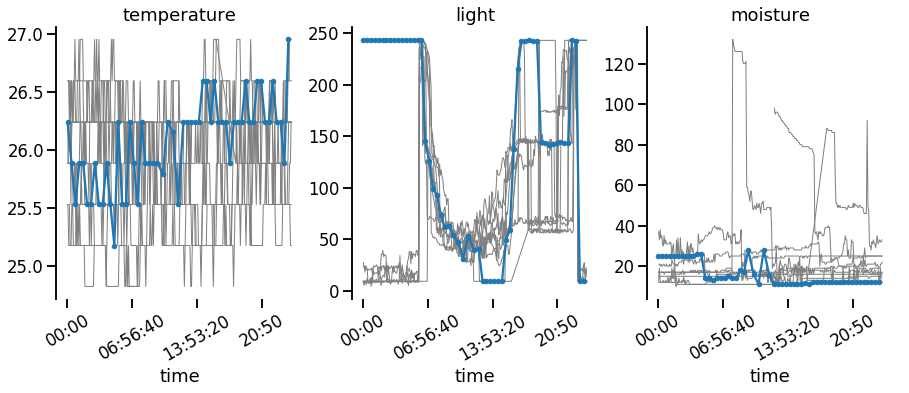

In [89]:
# I want to see the traces
sensor['time'] = sensor.ts.dt.time
means = sensor.groupby('time').agg(np.mean)
plt.figure(figsize=(15,5))
for s,sense in enumerate(['temperature', 'light', 'moisture']):
    plt.subplot(1,3,s+1)

    for date in sensor.ts.dt.date.unique():
        data = sensor[sensor.ts.dt.date==date]
        plt.plot(data.ts.dt.time, data[sense], '-', color='gray', lw=1)
    sns.despine(bottom=True)
    plt.plot(means[sense][::20], '.-')  # ticks every twenty minute
    plt.xticks(rotation=30)
    plt.title(sense)

# sending images to the server


In [13]:
import requests

fname = '../../plants/bottom left - 2018-12-17 13:00:02.jpg'  # arbitrarily choosen for testing
r = requests.post('http://192.168.1.190:5000/record/', files={'file':open(fname, 'rb')})
r.status_code

200

In [3]:
open(fname, 'rb')

<_io.BufferedReader name='../../plants/bottom left - 2018-12-17 13:00:02.jpg'>

In [8]:
r = requests.post('http://192.168.1.190:5000/record/')

# scanning for QR code

I put a QR code on the hydrofarm, can I write a function to scan and look for it?

I found this stackoverflow really helpful https://stackoverflow.com/questions/27233351/how-to-decode-a-qr-code-image-in-preferably-pure-python

In [14]:
# first generate the qr code
import pyqrcode
qr = pyqrcode.create("plants!")
qr.png("qrtest.png", scale=6)

In [59]:
# generate lots o' qr codes
import pyqrcode
for level in range(3):
    qr = pyqrcode.create("level_%s"%level)
    qr.png("level_%s.png"%level, scale=6)

manually move camera to find printed qr code. take snapshot. can we decode it?


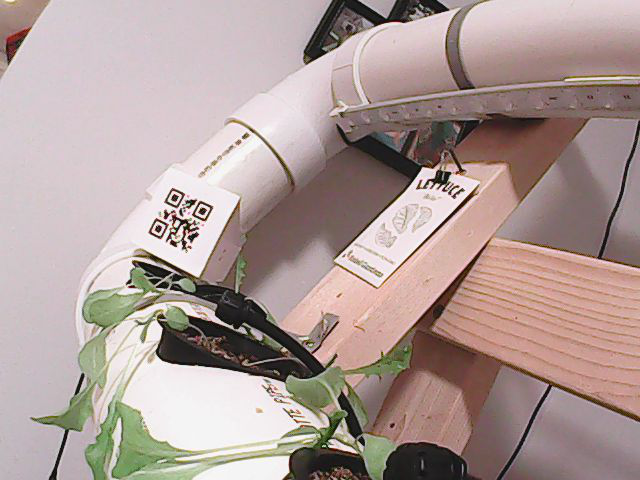

In [25]:
Image.open('../archive/QR_capture1.jpeg')

In [19]:
from PIL import Image
from pyzbar.pyzbar import decode
data = decode(Image.open('../qr_capture.jpeg'))
print(data)

[]


The code is far away and probably can't be decoded with such a low res camera - move it closer and see if that works.

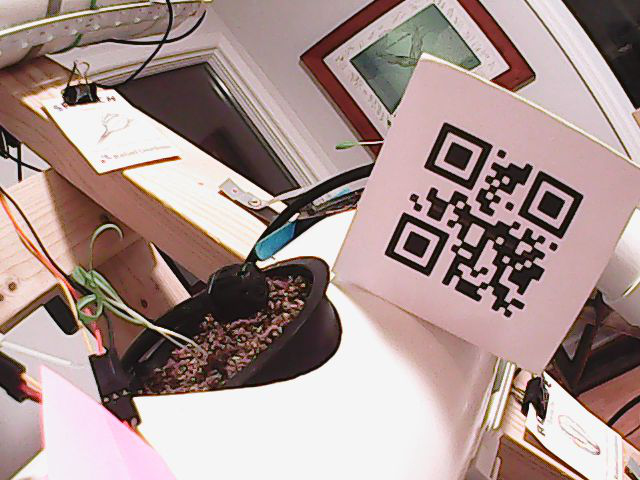

In [26]:
Image.open('../archive/QR_capture2.jpeg')

In [27]:
data = decode(Image.open('../archive/QR_capture2.jpeg'))
print(data)

[Decoded(data=b'plants!', type='QRCODE', rect=Rect(left=384, top=121, width=201, height=201), polygon=[Point(x=384, y=253), Point(x=518, y=322), Point(x=585, y=194), Point(x=445, y=121)])]


success!

# can I have it scan until it finds the code?

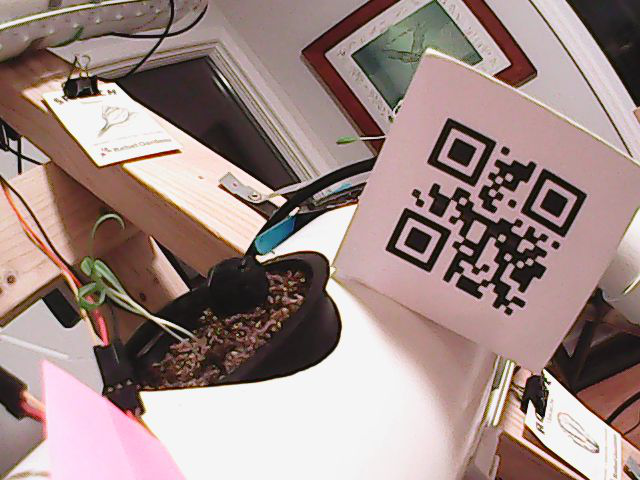

In [40]:
# first I need to scan from snapshot (as opposed to saving it)
r = requests.get('http://192.168.1.194:8080/?action=snapshot', stream=True)  # I don't know what "stream=True" means
Image.open(r.raw)

decoded []
qr: False


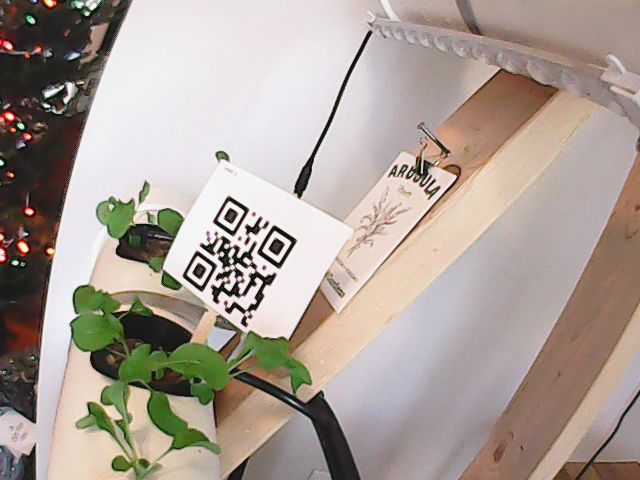

In [77]:
def check_for_qr():
    r = requests.get('http://192.168.1.194:8080/?action=snapshot', stream=True)  # I don't know what "stream=True" means
    decoded = decode(Image.open(r.raw))
    print('decoded', decoded)
    if decoded:
        return decoded[0].data
    return False

print('qr: %s'%check_for_qr())
r = requests.get('http://192.168.1.194:8080/?action=snapshot', stream=True)  # I don't know what "stream=True" means
Image.open(r.raw)

In [57]:
# scan
import time
reset = lambda: requests.get('http://192.168.1.194:8000/run/?action=camready')
go_right = lambda: requests.get('http://192.168.1.194:8000/run/?action=camright')
go_down = lambda: requests.get('http://192.168.1.194:8000/run/?action=camdown')

reset()
time.sleep(1)
for j in range(10):
    # set the down
    for _ in range(j): go_down()
    for i in range(10):
        go_right()
        time.sleep(0.5)
        status = check_for_qr()
        print (i, j, status)
        if status:
            break
    if status:
        break
    reset()
    

0 0 False
1 0 False
2 0 False
3 0 False
4 0 False
5 0 False
6 0 False
7 0 False
8 0 False
9 0 False
0 1 False
1 1 False
2 1 False
3 1 False
4 1 False
5 1 False
6 1 False
7 1 False
8 1 False
9 1 False
0 2 False
1 2 False
2 2 False
3 2 False
4 2 False
5 2 False
6 2 False
7 2 False
8 2 False
9 2 False
0 3 b'plants!'


In [54]:
[go_right()]*10


[<Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>,
 <Response [200]>]

In [51]:
reset()

<Response [200]>